In [1]:
import pandas as pd
import numpy as np

### Data Preprocessing

In [2]:
df = pd.read_csv('books.csv', on_bad_lines='skip')
df.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


In [3]:
df.rename(columns={'  num_pages': 'num_pages'}, inplace=True)
df.columns

Index(['bookID', 'title', 'authors', 'average_rating', 'isbn', 'isbn13',
       'language_code', 'num_pages', 'ratings_count', 'text_reviews_count',
       'publication_date', 'publisher'],
      dtype='object')

### Feature Engineering

In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Select relevant columns
features = df[['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count', 'language_code']]

# Encode categorical variables
label_encoder = LabelEncoder()
features['language_code'] = label_encoder.fit_transform(features['language_code'])

# Handle missing values (if any)
features = features.fillna(features.mean())

# Scale numerical features
scaler = StandardScaler()
features[['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']] = scaler.fit_transform(features[['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count']])

print(features.head())
#

   average_rating  num_pages  ratings_count  text_reviews_count  language_code
0        1.814493   1.308751      18.469833           10.498316              5
1        1.586228   2.212783      18.980766           11.130957              5
2        1.386496   0.064669      -0.103204           -0.115679              5
3        1.785960   0.408865      20.637902           13.888182              5
4        2.413689   9.760210       0.208768           -0.146729              5


/var/folders/4w/t_pbdxrn4t5d7m2tkwj7hfrr0000gn/T/ipykernel_66516/1831613191.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['language_code'] = label_encoder.fit_transform(features['language_code'])


In [20]:
from gensim.models import Word2Vec
import nltk
from nltk.tokenize import word_tokenize

# Ensure you have the necessary NLTK data files
nltk.download('punkt')
nltk.download('punkt_tab')

# Tokenize the 'title' and 'authors' columns
titles = df['title'].apply(word_tokenize).tolist()
authors = df['authors'].apply(word_tokenize).tolist()

# Combine the tokenized titles and authors
combined_text = titles + authors

# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=combined_text, vector_size=100, window=5, min_count=1, workers=4)

# Function to get the average Word2Vec vector for a list of words
def get_avg_word2vec_vector(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

# Convert 'title' and 'authors' columns to numerical features using the trained Word2Vec model
df['title_word2vec'] = df['title'].apply(lambda x: get_avg_word2vec_vector(word_tokenize(x), word2vec_model))
df['authors_word2vec'] = df['authors'].apply(lambda x: get_avg_word2vec_vector(word_tokenize(x), word2vec_model))

# Display the new columns
print(df[['title_word2vec', 'authors_word2vec']].head())

[nltk_data] Downloading package punkt to /Users/sumyea/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/sumyea/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


                                      title_word2vec  \
0  [-0.42789754, 0.33221427, 0.16238183, 0.253484...   
1  [-0.45071954, 0.31624684, 0.19426884, 0.363579...   
2  [-0.4590175, 0.3519123, 0.19188523, 0.3096615,...   
3  [-0.45100382, 0.34471723, 0.18851924, 0.304599...   
4  [-0.31334826, 0.28524527, 0.090487204, 0.06835...   

                                    authors_word2vec  
0  [-0.04150396, 0.019764414, 0.012901641, 0.0407...  
1  [-0.04150396, 0.019764414, 0.012901641, 0.0407...  
2  [-0.06111681, 0.02790067, 0.015683383, 0.05541...  
3  [-0.04150396, 0.019764414, 0.012901641, 0.0407...  
4  [-0.04150396, 0.019764414, 0.012901641, 0.0407...  


In [21]:
# Combine the feature dataframe with the title_word2vec and authors_word2vec columns
combined_features = pd.concat([features, df[['title_word2vec', 'authors_word2vec']]], axis=1)

# Display the combined features dataframe
print(combined_features.head())

   average_rating  num_pages  ratings_count  text_reviews_count  \
0        1.814493   1.308751      18.469833           10.498316   
1        1.586228   2.212783      18.980766           11.130957   
2        1.386496   0.064669      -0.103204           -0.115679   
3        1.785960   0.408865      20.637902           13.888182   
4        2.413689   9.760210       0.208768           -0.146729   

   language_code                                     title_word2vec  \
0              5  [-0.42789754, 0.33221427, 0.16238183, 0.253484...   
1              5  [-0.45071954, 0.31624684, 0.19426884, 0.363579...   
2              5  [-0.4590175, 0.3519123, 0.19188523, 0.3096615,...   
3              5  [-0.45100382, 0.34471723, 0.18851924, 0.304599...   
4              5  [-0.31334826, 0.28524527, 0.090487204, 0.06835...   

                                    authors_word2vec  
0  [-0.04150396, 0.019764414, 0.012901641, 0.0407...  
1  [-0.04150396, 0.019764414, 0.012901641, 0.0407...  
2  [-

### Recommendation Model

In [5]:
from sklearn.neighbors import NearestNeighbors

# Prepare the data for KNN
# Convert the 'title_word2vec' and 'authors_word2vec' columns to lists of floats
#combined_features['title_word2vec'] = combined_features['title_word2vec'].apply(lambda x: np.array(x))
#combined_features['authors_word2vec'] = combined_features['authors_word2vec'].apply(lambda x: np.array(x))

# Combine all features into a single numpy array
X = np.hstack([
    features[['average_rating', 'num_pages', 'ratings_count', 'text_reviews_count', 'language_code']].values
    #,np.vstack(combined_features['title_word2vec']),
    #np.vstack(combined_features['authors_word2vec'])
])

# Train the KNN model
knn = NearestNeighbors(n_neighbors=5, algorithm='auto').fit(X)

# Function to get book recommendations
def get_book_recommendations(book_index, knn_model, data, n_recommendations=5):
    distances, indices = knn_model.kneighbors([X[book_index]], n_neighbors=n_recommendations+1)
    recommendations = indices[0][1:]  # Exclude the first one as it is the input book itself
    return data.iloc[recommendations]

# Example usage: Get recommendations for the first book
recommended_books = get_book_recommendations(0, knn, df)
print(recommended_books[['title', 'authors', 'average_rating']])

                                                  title  \
1     Harry Potter and the Order of the Phoenix (Har...   
2114                                        Animal Farm   
2116                                  Lord of the Flies   
4415  Harry Potter and the Chamber of Secrets (Harry...   
3     Harry Potter and the Prisoner of Azkaban (Harr...   

                                      authors  average_rating  
1                  J.K. Rowling/Mary GrandPré            4.49  
2114  George Orwell/Boris Grabnar/Peter Škerl            3.93  
2116                          William Golding            3.68  
4415               J.K. Rowling/Mary GrandPré            4.42  
3                  J.K. Rowling/Mary GrandPré            4.56  


### Model Explanation With SHAP

In [99]:
import shap

# Initialize the SHAP explainer with the KNN model
X100 = shap.utils.sample(X, 100)
explainer = shap.KernelExplainer(lambda x: knn.kneighbors(x)[0], X100)

# Compute SHAP values for the first instance
shap_values = explainer.shap_values(X100[0])

# Plot the SHAP values
shap.initjs()
shap.plots.force(explainer.expected_value[0], shap_values[...,0], X100[0])

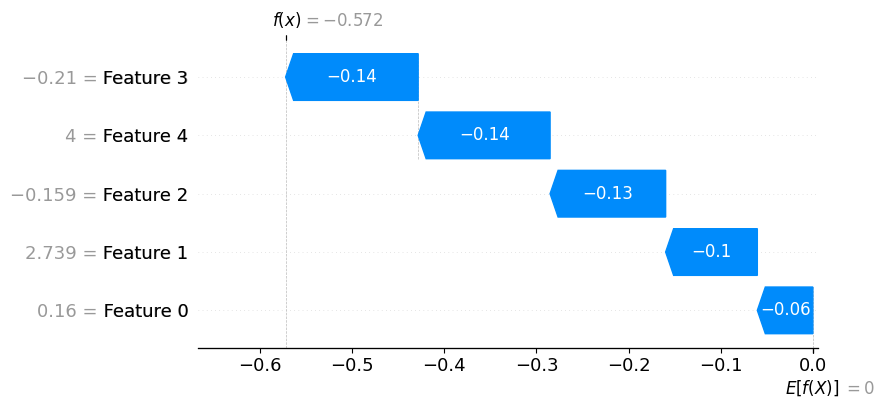

In [100]:
#shap_values = explainer.shap_values(X100)
shap_explanation = shap.Explanation(values=shap_values, base_values=explainer.expected_value, data=X100)
shap.plots.waterfall(shap_explanation[0])
#shap_explanation

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:03<00:00, 30.43it/s]


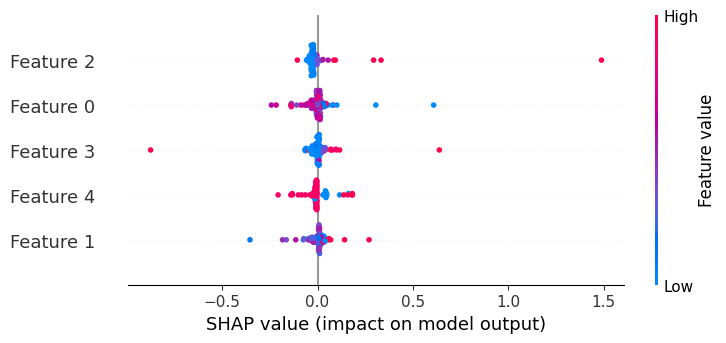

In [101]:
# Compute SHAP values for multiple instances
shap_values = explainer.shap_values(X100)

# Select the first output dimension for SHAP values
shap_values_1d = shap_values[..., 0]

# Plot the SHAP values using a beeswarm plot
shap_explanation = shap.Explanation(values=shap_values_1d, base_values=explainer.expected_value, data=X100)
shap.plots.beeswarm(shap_explanation)

100%|██████████| 100/100 [00:03<00:00, 30.25it/s]


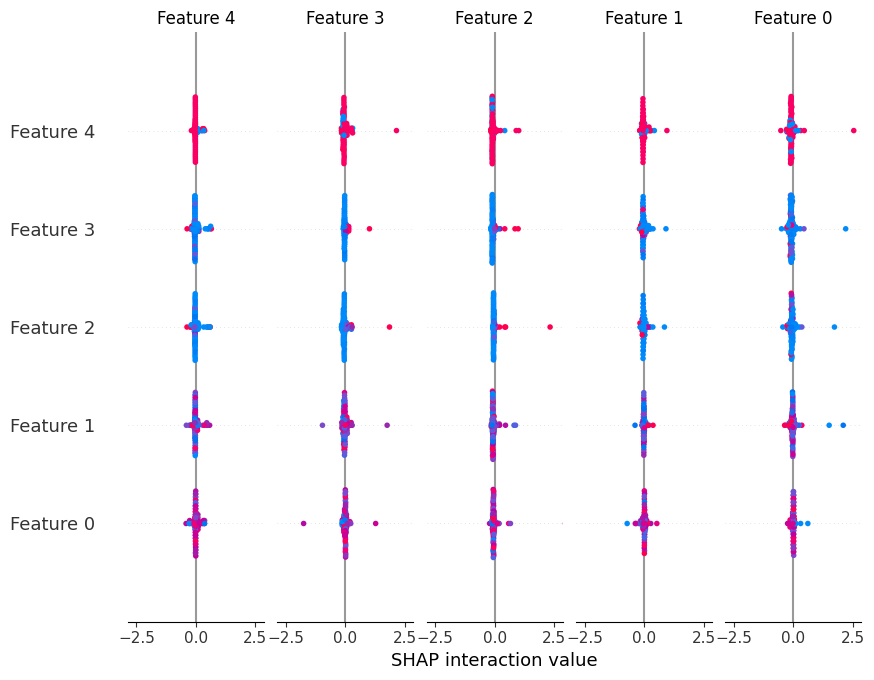

In [102]:
shap_values = explainer.shap_values(X100)
shap.summary_plot(shap_values, X100, plot_type="bar")

### Deployment

In [104]:
import joblib

# Save the KNN model
joblib.dump(knn, 'knn_model.pkl')

# Save the combined features and label encoder
joblib.dump(combined_features, 'combined_features.pkl')
#joblib.dump(label_encoder, 'label_encoder.pkl')

['combined_features.pkl']